In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


plt.rcParams.update({
    # --- Font and General Settings ---
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 12,
    "text.usetex": True,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    
    # --- Legend Settings ---
    "legend.frameon": True,
    "legend.fancybox": False,
    "legend.edgecolor": "black",
    "legend.framealpha": 1, 

    # --- Tick Direction and Visibility (All Sides) ---
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,        # Enable ticks on top
    "xtick.bottom": True,     # Enable ticks on bottom
    "ytick.left": True,       # Enable ticks on left
    "ytick.right": True,      # Enable ticks on right

    # --- Major Ticks (Bold) ---
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.major.width": 1.5, # Make major x-ticks bold (thicker)
    "ytick.major.width": 1.5, # Make major y-ticks bold (thicker)

    # --- Minor Ticks (Visible but not Bold) ---
    "xtick.minor.visible": True,  # Enable minor x-ticks
    "ytick.minor.visible": True,  # Enable minor y-ticks
    "xtick.minor.size": 3,        # Smaller size for minor ticks
    "ytick.minor.size": 3,
    "xtick.minor.width": 0.6,     # Default/Thin width for minor ticks
    "ytick.minor.width": 0.6,

    # --- The "Box" (Spines) Settings ---
    "axes.linewidth": 1.5,        # Make the box (spines) bold/thicker
})


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#000000", "#B4B4B4", "#7B72E2", "#73D89D", "#F77D7D", "#D7DC5E"])

# Load Data

In [2]:
data_path = "../data/results/HAMILTON RBG CS - 6153301 -- 20251221_164139 -- 9602/02_copula fitting/"

df_ranks = pd.read_csv(data_path + "01_input_ranks.csv")
df_metrics = pd.read_csv(data_path + "02_copula_fit_metrics.csv")
df_cdf = pd.read_csv(data_path + "03_cdf_results.csv")
if 'Analytical' in df_cdf.columns:
    cols = ['Analytical'] + [c for c in df_cdf.columns if c != 'Analytical']
    df_cdf = df_cdf[cols]

df_return_periods = pd.read_csv(data_path + "04_return_periods.csv")
if 'Analytical' in df_return_periods.columns:
    cols = ['Analytical'] + [c for c in df_return_periods.columns if c != 'Analytical']
    df_return_periods = df_return_periods[cols]

print("Data loaded successfully.")
display(df_metrics)

Data loaded successfully.


,Family,param,df,LogLik,AIC,BIC,taildep.lower,taildep.upper,tau
0,Gaussian,0.867239,NaN,1019.779347,-2037.558693,-2031.977994,0.000000,0.000000,0.668215
1,t,0.867239,4.0,1061.195150,-2118.390301,-2107.228901,0.270893,0.270893,0.668215
2,Clayton,4.028002,NaN,1253.953493,-2505.906985,-2500.326285,NaN,NaN,0.668215
3,Frank,10.091377,NaN,1026.149876,-2050.299751,-2044.719051,NaN,NaN,0.668215
4,Gumbel,3.014001,NaN,755.198040,-1508.396080,-1502.815380,NaN,NaN,0.668215


# 1. Input Data Ranks (Dependency Structure)

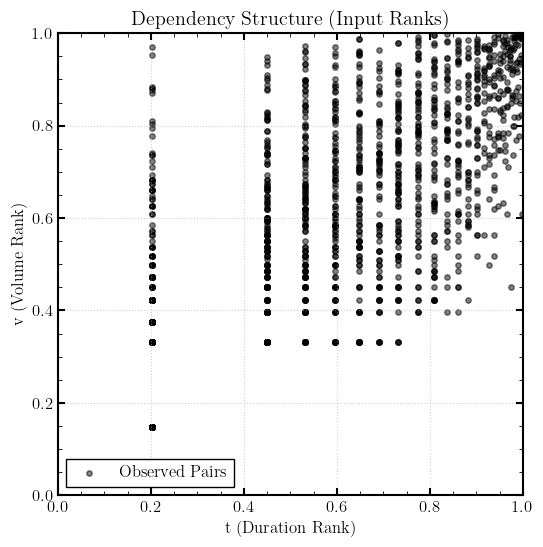

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(df_ranks['u_duration'], df_ranks['v_volume'], alpha=0.5, s=15, color='black', label='Observed Pairs')
plt.xlabel('t (Duration Rank)')
plt.ylabel('v (Volume Rank)')
plt.title('Dependency Structure (Input Ranks)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 2. Copula Fit Metrics Comparison

In [21]:
# Melt for seaborn plotting
metrics_melted = df_metrics.melt(id_vars=['Family'], value_vars=['AIC', 'BIC'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Family', y='Value', hue='Metric', palette="grey")
plt.title('Goodness-of-Fit Metrics (AIC & BIC)')
plt.ylabel('Score (Lower is Better)')
plt.xlabel('Copula Family')
plt.legend(title='Metric')
plt.show()

RuntimeError: latex was not able to process the following string:
b'Goodness-of-Fit Metrics (AIC & BIC)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpny2p4oyq e3f419e30f4eb198ac308bf09f68575e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e3f419e30f4eb198ac308bf09f68575e.tex
LaTeX2e <2023-11-01>
L3 programming layer <2023-11-09>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e3f419e30f4eb198ac308bf09f68575e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\rmfamily Goodness-of-Fit Metrics (AIC &
                                               BIC)}%
No pages of output.
Transcript written on tmpny2p4oyq/e3f419e30f4eb198ac308bf09f68575e.log.




<Figure size 1000x600 with 1 Axes>

# 3. CDF Comparison

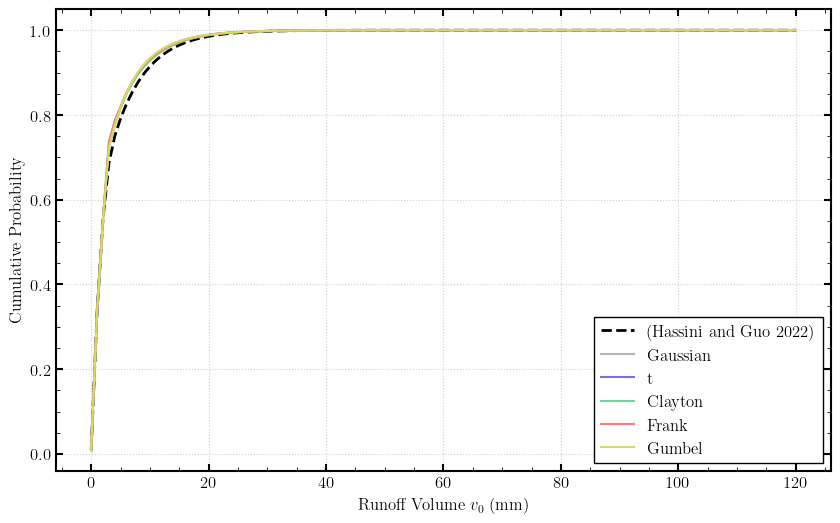

In [11]:
plt.figure(figsize=(10, 6))
for col in df_cdf.columns:
    if col != 'v0':
        # Highlight the 'Analytical' or best fit if known, otherwise just plot all
        lw = 2 if col == 'Analytical' else 1.5
        ls = '--' if col == 'Analytical' else '-'
        label =  "(Hassini and Guo 2022)" if col == "Analytical" else col
        plt.plot(df_cdf['v0'], df_cdf[col], label=label, linewidth=lw, linestyle=ls)

plt.xlabel(r'Runoff Volume $v_0$ (mm)')
plt.ylabel('Cumulative Probability')
# plt.title('CDF Comparison of Fitted Copulas')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# 4. Return Periods Analysis

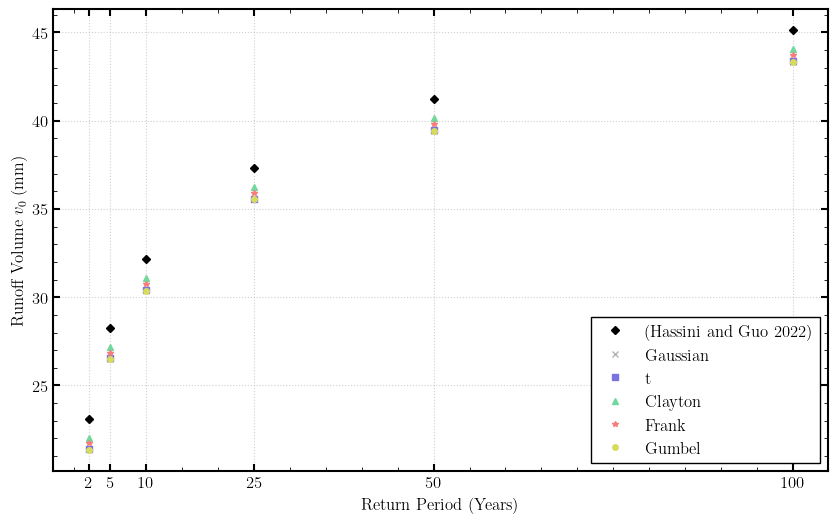

In [9]:
from matplotlib.ticker import MultipleLocator 

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_prop_cycle(color=["#000000", "#B4B4B4", "#7B72E2", "#73D89D", "#F77D7D", "#D7DC5E"], marker=['D', 'x', 's', '^', '*', 'o'])
for i, col in enumerate(df_return_periods.columns):
    if col != 'ReturnPeriod':
        label =  "(Hassini and Guo 2022)" if col == "Analytical" else col
        ax.plot(df_return_periods['ReturnPeriod'], df_return_periods[col], markersize=4, label=label, linestyle="")

plt.xlabel('Return Period (Years)')
plt.ylabel(r'Runoff Volume $v_0$ (mm)')
ax.set_xticks(df_return_periods['ReturnPeriod'])
ax.xaxis.set_minor_locator(MultipleLocator(5)) 
# plt.title('Return Period Analysis')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()